In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print("hi")

hi


## ML Libraries

In [3]:
# import matplotlib.image as mpimg
# from skimage.io import imread, imshow
# !pip install scikit-image --quiet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.nn.utils import clip_grad_norm
from tqdm.notebook import tqdm

cudnn.benchmark = True
torch.manual_seed(42)

## Show Samples

In [4]:
# fig, axes = plt.subplots(1, 4, figsize=(18, 8))

# ALASKA2_ROOT_PATH = '/kaggle/input/alaska2-image-steganalysis/'

# sample_cover = imread(ALASKA2_ROOT_PATH + 'Cover/00001.jpg')
# sample_jmipod = imread(ALASKA2_ROOT_PATH + 'JMiPOD/00001.jpg')
# sample_juniward = imread(ALASKA2_ROOT_PATH + 'JUNIWARD/00001.jpg')
# sample_uerd = imread(ALASKA2_ROOT_PATH + 'UERD/00001.jpg')

# axes[0].imshow(sample_cover)
# axes[1].imshow(sample_jmipod)
# axes[2].imshow(sample_juniward)
# axes[3].imshow(sample_uerd)

# # train_cover_paths = [ALASKA2_ROOT_PATH + path for path in os.listdir(ALASKA2_ROOT_PATH + 'Cover')[:4]]
# # print(train_cover_paths)
# # print(len(os.listdir(ALASKA2_ROOT_PATH + 'Cover')))
# # print(sample_cover.shape)
# # print(torch.from_numpy(sample_cover).permute(2, 0, 1).shape)
# # print(Image.open(ALASKA2_ROOT_PATH + 'Cover/00001.jpg'))

In [5]:
# !mkdir /kaggle/working/lsb

In [6]:
# from torchvision import transforms
# print(transforms.PILToTensor()(Image.open('/kaggle/input/alaska2-image-steganalysis/Cover/00001.jpg')))

## Load and Transform Data

In [7]:
from torchvision.transforms import v2
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn.functional import one_hot

ALASKA2_ROOT_PATH = '/kaggle/input/alaska2-image-steganalysis/'
# If we want to add rotation
# rotation_angles = [90, 180, 270]
# random_rotation = transforms.Compose([
#     transforms.RandomChoice([transforms.RandomRotation(angle) for angle in rotation_angles])
# ])

train_transform = v2.Compose([
    transforms.PILToTensor(),
    v2.RandomHorizontalFlip(), # Random augmentations
    v2.RandomVerticalFlip(),
#     v2.ToImageTensor(),
    v2.ToDtype(torch.float32), # int -> float
    v2.Lambda(lambda x: x / 255.0),
    v2.Normalize(mean=[0.3914976, 0.44266784, 0.46043398], std=[0.17819773, 0.17319807, 0.18128773]), # normalize channels based on ImageNet dataset (what Inception was trained on)
])

# [0.4574, 0.4400, 0.3902]
# [0.1707, 0.1630, 0.1657]

val_transform = v2.Compose([
#     v2.ToImageTensor(),
    transforms.PILToTensor(),
#     v2.RandomHorizontalFlip(), # Random augmentations
#     v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float32), # int -> float
    v2.Lambda(lambda x: x / 255.0),
    v2.Normalize(mean=[0.3914976, 0.44266784, 0.46043398], std=[0.17819773, 0.17319807, 0.18128773]), # normalize based on alaska2 metrics
])

def get_paths(root_path, labels, split, end=75000, oversample=False):
    train_label_paths_array = []
    val_label_paths_array = []
    
    for label in labels:
        path = root_path + label + '/'
        train_label_paths = [path + file_name for file_name in os.listdir(path)[:split]]
        val_label_paths = [path + file_name for file_name in os.listdir(path)[split:end]]
        
        train_label_paths_array.append(train_label_paths)
        val_label_paths_array.append(val_label_paths)
        
    train_paths = []
    val_paths = []
    
     # 'Cover' paths must be first in array
    for i, cover_path in enumerate(train_label_paths_array[0]):
        if not oversample:
            train_paths.append(cover_path)
        for j in range(1, 4): # 1, 2 ,3
            if oversample:
                train_paths.append(cover_path)
            train_paths.append(train_label_paths_array[j][i])            
                
        
    for i, cover_path in enumerate(val_label_paths_array[0]):
        if not oversample:
            val_paths.append(cover_path)
        for j in range(1, 4): # 1, 2 ,3
            if oversample:
                val_paths.append(cover_path)
            val_paths.append(val_label_paths_array[j][i]) 
    
    return train_paths, val_paths

classes = ['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']

num_classes = len(classes)

label2id = {
    "Cover": 0,
    "JMiPOD": 1,
    "JUNIWARD": 2,
    "UERD": 3
}

# 80/20 split
# split = 25600
# end = 32000
split = 60000
end = 75000

train_paths, val_paths = get_paths(ALASKA2_ROOT_PATH, classes, split=split, end=end, oversample=True)
            
print(train_paths[:10])   
print(val_paths[:10])   
    
def get_labels(paths, multiclass=True):
    labels = []
    for path in paths:
        if "Cover" in path:
            labels.append(0)
        elif multiclass is not True:
            labels.append(1)
        elif "JMiPOD" in path:
            labels.append(1)
        elif "JUNIWARD" in path:
            labels.append(2)
        else: # UERD
            labels.append(3)
    return labels

# train_labels = one_hot(torch.tensor(get_labels(train_paths)), num_classes=num_classes).float()
# val_labels = one_hot(torch.tensor(get_labels(val_paths)), num_classes=num_classes).float()

train_labels = get_labels(train_paths, multiclass=True)
val_labels = get_labels(val_paths, multiclass=True)
    
print(train_labels[:10])
print(val_labels[:10])
print(np.unique(train_labels, return_counts=True))
print(np.unique(val_labels, return_counts=True))
# print(one_hot(torch.tensor(train_labels), num_classes=num_classes))
    
# all_images = torch.from_numpy(all_images).permute(0,3,1,2).float()
# all_labels = torch.from_numpy(all_labels)
class Alaska2Dataset(Dataset):

    def __init__(self, full_paths, labels, transform=None):
        self.full_paths = full_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.full_paths)

    def __getitem__(self, idx):
        image = Image.open(self.full_paths[idx])
        if self.transform:
            # Apply transformations
            image = self.transform(image)
        return image, self.labels[idx]
    
    ## Setup train and val dataloaders
image_datasets = []    
train_dataset = Alaska2Dataset(train_paths, train_labels, transform=train_transform)
val_dataset = Alaska2Dataset(val_paths, val_labels, transform=val_transform)

# 32 works for normal resnet50layers
# 18
batch_size = 16
num_workers = 4

dataloaders = {
    "train": torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers),
    "val": torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
}
dataset_sizes = {
    "train": len(train_paths),
    "val": len(val_paths)
}

print(f'Train len: {dataset_sizes["train"]}')
print(f'Val len: {dataset_sizes["val"]}')

# i = 0
# for inputs, labels in iter(dataloaders["train"]):
#     i += 1

# Use Cuda (GPU) if we can
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   
print(device)

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

['/kaggle/input/alaska2-image-steganalysis/Cover/64601.jpg', '/kaggle/input/alaska2-image-steganalysis/JMiPOD/64601.jpg', '/kaggle/input/alaska2-image-steganalysis/Cover/64601.jpg', '/kaggle/input/alaska2-image-steganalysis/JUNIWARD/64601.jpg', '/kaggle/input/alaska2-image-steganalysis/Cover/64601.jpg', '/kaggle/input/alaska2-image-steganalysis/UERD/64601.jpg', '/kaggle/input/alaska2-image-steganalysis/Cover/31973.jpg', '/kaggle/input/alaska2-image-steganalysis/JMiPOD/31973.jpg', '/kaggle/input/alaska2-image-steganalysis/Cover/31973.jpg', '/kaggle/input/alaska2-image-steganalysis/JUNIWARD/31973.jpg']
['/kaggle/input/alaska2-image-steganalysis/Cover/09872.jpg', '/kaggle/input/alaska2-image-steganalysis/JMiPOD/09872.jpg', '/kaggle/input/alaska2-image-steganalysis/Cover/09872.jpg', '/kaggle/input/alaska2-image-steganalysis/JUNIWARD/09872.jpg', '/kaggle/input/alaska2-image-steganalysis/Cover/09872.jpg', '/kaggle/input/alaska2-image-steganalysis/UERD/09872.jpg', '/kaggle/input/alaska2-image

In [8]:
# total_mean_sum = torch.zeros(3)
# total_std_sum = torch.zeros(3)
# total_count = 0

# for index, (inputs, labels) in enumerate(iter(dataloaders["train"])):
# #     print(inputs.shape)
# #     print(inputs[0, :])
#     inputs = inputs.view(inputs.size(0), inputs.size(1), -1) # (N, C, H*W)
#     batch_channel_means = torch.mean(inputs, dim=2) # Get mean for each channel
#     batch_channel_stds = torch.std(inputs, dim=2)
    
# #     print(batch_channel_means)
    
#     total_mean_sum += torch.sum(batch_channel_means, dim=0)
#     total_std_sum += torch.sum(batch_channel_stds, dim=0)
#     total_count += inputs.size(0) # batch_size 
    
#     if index % 100 == 0 and index != 0:
#         break;
        
# print(total_mean_sum)
# print(total_count)

# print(total_mean_sum / total_count)
# print(total_std_sum / total_count)

# # print(inputs[0,:])
# # view = inputs.view(inputs.size(0), inputs.size(1), -1) # 
# # print(view.shape)
# # channel_means = torch.mean(view, 2)
# # print(channel_means)
# # overall_mean = torch.mean(channel_means, 0)
# # print(overall_mean)

## Define Pre-Trained Model

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

# from torchvision.models.vision_transformer import vit_b_32, ViT_B_32_Weights, vit_l_32, ViT_L_32_Weights

# Load the pre-trained Resnet50 model
# resnet50 = models.resnet50(pretrained=True)
# resnet50 = models.resnet50(weights="IMAGENET1K_V2")

# Loads standard Vision Transformer with 32x32 patch size
# model = vit_l_32(image_size=512)

# ViT.fc = torch.nn.Linear(1000, num_classes)

# model.heads.add_module("fc", torch.nn.Linear(1000, num_classes))

# Simple Attention Module, alternative to avg pooling
class SimpleAttention(nn.Module):
    def __init__(self, in_channels):
        super(SimpleAttention, self).__init__()
        # n_channels (1280 for effnet) weights, each 1x1 filter has it's own weight
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1, stride=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        weights = self.sigmoid(self.conv(x))
        attended_input = x * weights
        return attended_input

# (7): Conv2dNormActivation(
#       (0): Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
#       (1): BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
#       (2): SiLU(inplace=True)
#     )
# (avgpool): AdaptiveAvgPool2d(output_size=1)
# (classifier): Sequential(
#   (0): Dropout(p=0.2, inplace=True)
#   (1): Linear(in_features=1280, out_features=1000, bias=True)
#   (fc): Linear(in_features=1000, out_features=4, bias=True)
# )


num_classes = 4  # Number of classes (for multiclass)
multiclass = True

# model_name = "resnet50"

# Trying non-pretrained
# model = models.resnet50(weights=None) # ~23m parameters

# For freezing the weights
# for param in resnet50.parameters():
#     param.requires_grad = False

# model.fc = torch.nn.Linear(2048, num_classes)  # Modify the classifier layer

model_name = "efficientnet_v2_s_no_shuffle"
model = torchvision.models.efficientnet_v2_s() # ~21m parameters
model.avgpool = nn.Sequential(
            SimpleAttention(1280),
            nn.AdaptiveAvgPool2d(output_size=1)
        )
model.classifier = torch.nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, num_classes) if multiclass else nn.Linear(1280, 1)
        )
# model.classifier.add_module("fc", torch.nn.Linear(1000, num_classes))


print(model_name)
# print(model.fc)

print(model.features[7])
print(model.avgpool)
print(model.classifier)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))
# print(count_parameters(resnet50))

# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
#     def forward(self, x):
#         return x
    
# # Trying to remove initial maxpool layer
# resnet50.maxpool = Identity()
# print(resnet50)

# inputs, labels = next(iter(dataloaders["train"]))

# inputs = inputs[0:2, :]
# print(inputs.shape, labels.data)

# outputs = ViT(inputs)
# print(outputs)
# print(outputs.shape)
# out, preds = torch.max(outputs, 1)
# print(out)
# print(preds)
# print(preds.shape)

efficientnet_v2_s_no_shuffle
Conv2dNormActivation(
  (0): Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)
Sequential(
  (0): SimpleAttention(
    (conv): Conv2d(1280, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (sigmoid): Sigmoid()
  )
  (1): AdaptiveAvgPool2d(output_size=1)
)
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)
20183892


## Train Function

In [16]:
from torch.nn.utils import clip_grad_norm_
import pickle

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25,multiclass=True, clip_value=1, verbose=False):
    since = time.time()

    train_losses = []
    train_accs = []
    
    val_losses = []
    val_accs = []
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, f'{model_name}_GPU_best_weights.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        print(f'{num_epochs} epochs')
        for epoch in range(num_epochs):
            epoch_since = time.time()
            
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    print('training')
                else:
                    model.eval()   # Set model to evaluate mode
                    print('evaluating')

                running_loss = 0.0
                running_corrects = 0

                i = 0
                # Iterate over data.
                progress_bar = tqdm(dataloaders[phase], total=dataset_sizes[phase] // batch_size)
                for inputs, labels in progress_bar:
#                 for inputs, labels in dataloaders[phase]:    
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients (don't accumulate)
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        preds = None
                        if multiclass:  
                            _, preds = torch.max(outputs, 1)
                        else:
                            preds = (outputs >= 0.5).int()
                                                       
                        loss = criterion(outputs, labels)    
                        if verbose and i % 30 == 0:
                            print("unique preds: ", torch.unique(preds, return_counts=True))
                            print("labels:", torch.unique(labels, return_counts=True))  
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            
                            # Trying to avoid a NaN loss (gradient clipping)
#                             clip_grad_norm_(model.parameters(), clip_value)
                            
                            optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0) # loss * batch size                
                    running_corrects += torch.sum(preds == labels).item()
                    
                    total_so_far = (i + 1) * batch_size
                    
                    if i % 10 == 0:
                        progress_bar.set_postfix_str(f'Avg Accuracy: {float(running_corrects) / total_so_far} Avg Loss: {running_loss / total_so_far}')
                    
                    if verbose and i % (dataset_sizes[phase] // batch_size // 15 + 1) == 0:
                        print(f'{phase} Batch: {i + 1} (total of {total_so_far} images) Avg Accuracy: {float(running_corrects) / total_so_far} Avg Loss: {running_loss / total_so_far}')                                                
                    i += 1
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = float(running_corrects) / dataset_sizes[phase]
                
                if phase == 'train' and scheduler is not None:
                    scheduler.step(epoch_loss) 
                
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')            
                
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            
            # Save checkpoints          
            print(f'Saving checkpoint after epoch {epoch}')
            torch.save(model.state_dict(), f'/kaggle/working/{model_name}_GPU_train_n_{dataset_sizes["train"]}_epoch_{epoch}.pt')
            with open(f'/kaggle/working/{model_name}_GPU_train_n_{dataset_sizes["train"]}_running_history.pkl', 'wb') as file:
                pickle.dump({"train_losses": train_losses, "train_accs": train_accs, "val_losses": val_losses, "val_accs": val_accs}, file)

            
            print(f"Time For Epoch {epoch}: {time.time() - epoch_since}")

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

# Try to free some memory

In [10]:
# torch.cuda.empty_cache()
del train_dataset, val_dataset
# import gc
# print(gc.get_objects())
# gc.collect()

# del 

In [11]:
# print(gc.get_objects())
import gc
gc.collect()
# torch.cuda.empty_cache()

0

In [ ]:
# inputs, labels = next(iter(dataloaders["train"]))

# inputs = inputs.to(device)
# labels = labels.to(device)
# model = model.to(device)
# outputs = model(inputs)

# loss = nn.CrossEntropyLoss()(outputs, labels)

# print(outputs)
# _, preds = torch.max(outputs, dim=1)
# print(preds)
# print(loss)

## Loss, Optimizer, and Scheduler

In [17]:
pos_weight = torch.tensor([1, 3]) # Only 1/4 of data is 'Cover' image
weight = torch.tensor([1., 3., 3., 3.])

criterion = nn.CrossEntropyLoss(weight=weight) if multiclass else nn.BCELoss(pos_weight=pos_weight)
criterion = criterion.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# probably use gradient clipping for Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4, eps=1e-8)
# Decay LR by a factor of 0.1 every 3 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, min_lr=1e-8, factor=0.1, verbose=True)

## Training

In [ ]:
# resnet50 = resnet50.to(device)
checkpoint = True
# checkpoint_path = '/kaggle/input/effnetgpu/efficientnetv2_s_GPU_train_n_240000_epoch_5.pt'
# checkpoint_path = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_epoch_2.pt'
# checkpoint_path = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_epoch_2 (1).pt'
checkpoint_path = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_epoch_2_phase_3.pt'

if checkpoint:
    model.load_state_dict(torch.load(checkpoint_path))
    print(f'loaded checkpoint at {checkpoint_path}')

model = model.to(device)

num_epochs = 3

model = train_model(model, criterion, optimizer, scheduler=lr_scheduler,
                       num_epochs=num_epochs, multiclass=True, verbose=True)
torch.save(model.state_dict(), f"/kaggle/working/{model_name}_final.pt")

In [ ]:
# del model


## Plotting

loaded checkpoint at /kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_epoch_2_phase_3.pt
[0 1 0 ... 0 1 0]
[3 1 0 ... 0 1 0]


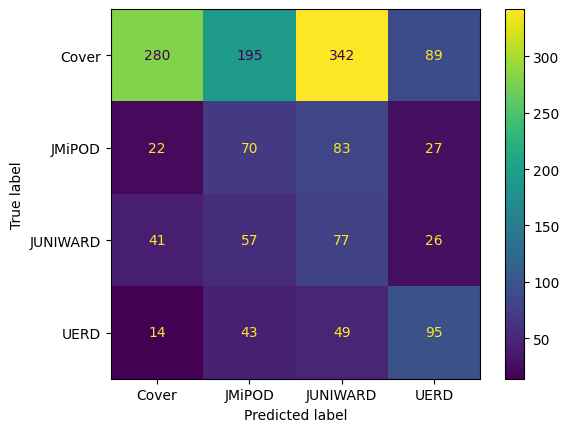

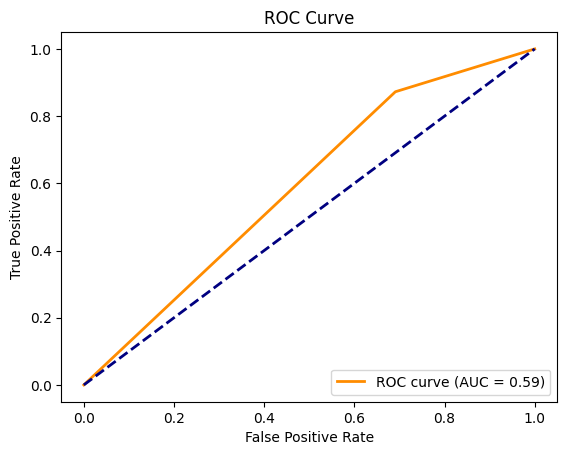

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

# torch.cuda.empty_cache()
checkpoint = False
# checkpoint_path = '/kaggle/working/efficientnetv2_s_GPU_train_n_16000_epoch_7.pt'
# checkpoint_path = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_epoch_2 (1).pt'
checkpoint_path = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_epoch_2_phase_3.pt'
# model = model.to(device)

if checkpoint:
    model.load_state_dict(torch.load(checkpoint_path))
    print(f'loaded checkpoint at {checkpoint_path}')

# Initialize empty lists for true labels and predicted probabilities
y_true = []
y_pred = []

# Iterate over the validation dataset to get true labels and predicted probabilities
i = 0
print('evaluting for plot')
for images, labels in iter(dataloaders["val"]):    
#     if i > (val_len // batch_size):
#         break;
    images = images[:5]
    labels = labels[:5]
    images = images.to(device)
    y_true.append(labels.numpy()) 
    out = model(images)
    _, preds = torch.max(out, dim=1)
    y_pred.append(preds.cpu())
            
#     if i > 300:
#         break;
#     i += 1

# Concatenate the lists to obtain numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
print(y_true)
print(y_pred)
# print(y_pred_prob)
# print(y_true)
# print(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=classes).plot()

y_true_binary = np.where(y_true > 0, 1, 0)
y_pred_binary = np.where(y_pred > 0, 1, 0)

print("Accuracy: ", np.sum(y_true_binary == y_pred_binary) / len(y_true_binary))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Accuracy and Loss Graphs

{'train_losses': [1.3799130344814725, 1.3530458589553833, 1.3339827456739213, 1.3198508090019225, 1.3050298090245989, 1.28969014816814, 1.2440399251884884, 1.1826214070638021, 1.1358187682734595], 'train_accs': [0.27182222222222224, 0.30485833333333334, 0.31480555555555556, 0.3138222222222222, 0.31730555555555556, 0.33145277777777776, 0.35473055555555555, 0.39996944444444443, 0.4315777777777778], 'val_losses': [23.108269231435987, 22.620708597056073, 5.33451632654402, 6.382974752193027, 1.6131487219280667, 1.8124235929701062, 1.9641173878563776, 2.503284789043003, 2.5759453126271565], 'val_accs': [0.18894444444444444, 0.2633333333333333, 0.29573333333333335, 0.39076666666666665, 0.30396666666666666, 0.2599666666666667, 0.2579666666666667, 0.2419888888888889, 0.29106666666666664]}


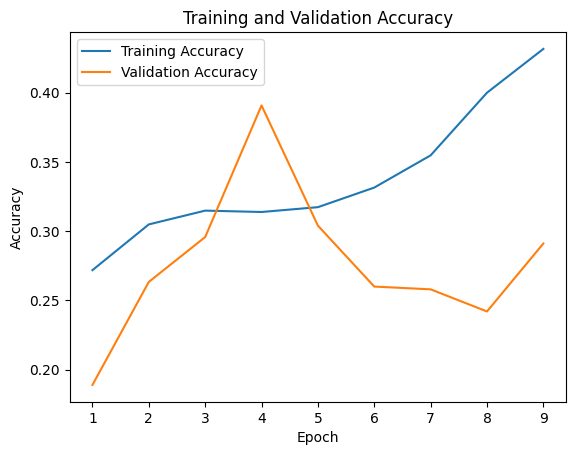

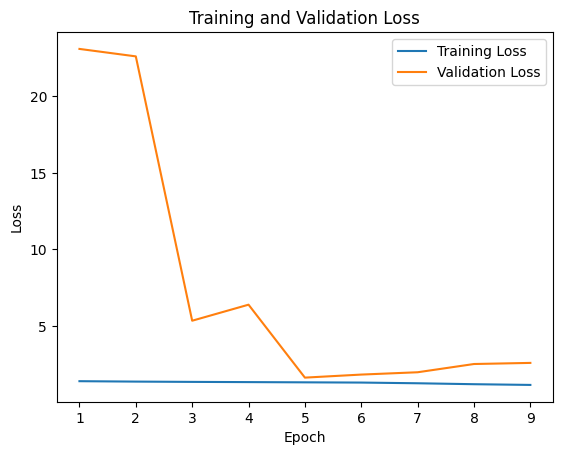

In [15]:
# Accuracy and Loss Graphs
# history = model.fit(train_data, epochs=num_epochs, validation_data=validation_data)
import pickle
import matplotlib.pyplot as plt

# running_history = True
# path = '/kaggle/working/efficientnetv2_s_GPU_train_n_16000_running_history.pkl'
# path = f'/kaggle/working/{model_name}' + ('.pretrained' if pretrained else '') + f'.train-n-{train_len}.' + ('running_history.pkl' if running_history else 'final_history.pkl'
# path = f'/kaggle/working/{model_name}_GPU_train_n_{dataset_sizes["train"]}_running_history.pkl'
path1 = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_running_history.pkl'
path2 = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_running_history_2.pkl'
path3 = '/kaggle/input/effnetv2-oversampled/efficientnet_v2_s_no_shuffle_GPU_train_n_360000_running_history_3.pkl'
                                                                                                             
with open(path1, 'rb') as file:
    history1 = pickle.load(file)
with open(path2, 'rb') as file:
    history2 = pickle.load(file)
with open(path3, 'rb') as file:
    history3 = pickle.load(file)
    
history = {}
for key in history1:
    history[key] = history1[key] + history2.get(key, []) + history3.get(key, []) # empty array as default
# # else:
# #     history = history.history

print(history)

num_epochs = 9

plt.figure()
plt.plot(range(1, num_epochs + 1), history['train_accs'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history['val_accs'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), history['train_losses'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history['val_losses'], label='Validation Loss')
# plt.ylim(top=3)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Using with TPU

In [ ]:
# !pip install torch

In [ ]:
# # Step 1: Install Torch-XLA (PyTorch with Accelerated Linear Algebra (XLA) support)
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

# import torch_xla
# import torch_xla.debug.metrics as met
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.utils.utils as xu
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.test.test_utils as test_utils
# from transformers import AdamW

# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
# # os.environ['XLA_USE_BF16']="1"
# os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

# gc.collect()

# model = ViT

In [ ]:
# !tpustatus

In [ ]:
# device = xm.xla_device()
# model = model.to(device)

# train_sampler = torch.utils.data.distributed.DistributedSampler(
#           train_dataset,
#           num_replicas=xm.xrt_world_size(), # tell PyTorch how many devices (TPU cores) we are using for training
#           rank=xm.get_ordinal(), # tell PyTorch which device (core) we are on currently
#           shuffle=True)

# train_data_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     sampler=train_sampler,
#     drop_last=True,
#     num_workers=0,
# )

# inputs, labels = next(iter(train_data_loader))

# inputs = inputs.to(device)

# outputs = model()

## Slightly different train/val functions

In [ ]:
# def reduce_fn(vals):
#     # take average
#     return sum(vals) / len(vals)

# def train_loop_fn(data_loader, model, optimizer, criterion, device, scheduler=None, clip_value=5):
#     model.train() # put model in training mode
#     for index, (inputs, labels) in enumerate(data_loader): # enumerate through the dataloader

#         # put tensors onto desired device, in this case the TPU core
#         inputs = inputs.to(device, dtype=torch.float) 
#         labels = labels.to(device, dtype=torch.long)

#         # don't accumulate gradients across batches
#         optimizer.zero_grad()
        
#         # feed through network
#         outputs = model(inputs)
        
#         # calculate loss (cross entropy)
#         loss = criterion(preds, labels)
#         if index % 50 == 0:
#             # since the loss is on all 8 cores, reduce the loss values and print the average (as defined in reduce_fn)
#             loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
#             # master_print will only print once (not from all 8 cores)
#             xm.master_print(f'batch={index + 1}, loss={loss_reduced}')
            
#         # backpropagate
#         loss.backward()
        
#         # gradient clipping
#         clip_grad_norm_(model.parameters(), clip_value)
        
#         # Use PyTorch XLA optimizer stepping
#         xm.optimizer_step(optimizer)
#         if scheduler is not None:
#             scheduler.step()
    
# def eval_loop_fn(data_loader, model, device):
#     model.eval() 
#     running_corrects = 0
#     for index, (inputs, labels) in enumerate(data_loader): # enumerate through dataloader
#         # put tensors onto desired device, in this case the TPU core
#         inputs = inputs.to(device, dtype=torch.float)
#         labels = labels.to(device, dtype=torch.long)

#         outputs = model(inputs) 
#         _, preds = torch.max(outputs, dim=1) # get predicted labels
        
# #         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)
        
#     return running_corrects

In [ ]:
# def run_training_process():
#     # Define training params 
# #     MAX_LEN = 192 # maximum text length in the batch (cannot have too high due to memory constraints)
#     BATCH_SIZE = 16 # batch size (cannot have too high due to memory constraints)
#     EPOCHS = 20 # number of epochs

#     # defining data samplers and loaders 
#     train_sampler = torch.utils.data.distributed.DistributedSampler(
#           train_dataset,
#           num_replicas=xm.xrt_world_size(), # tell PyTorch how many devices (TPU cores) we are using for training
#           rank=xm.get_ordinal(), # tell PyTorch which device (core) we are on currently
#           shuffle=True)

#     train_data_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=BATCH_SIZE,
#         sampler=train_sampler,
#         drop_last=True,
#         num_workers=0,
#     )
        
#     val_sampler = torch.utils.data.distributed.DistributedSampler(
#           val_dataset,
#           num_replicas=xm.xrt_world_size(),
#           rank=xm.get_ordinal(),
#           shuffle=False)

#     val_data_loader = torch.utils.data.DataLoader(
#         val_dataset,
#         batch_size=BATCH_SIZE,
#         sampler=val_sampler,
#         drop_last=False,
#         num_workers=0
#     )    

#     device = xm.xla_device() # our device (single TPU core)
#     model = model.to(device) # put model onto the TPU core
#     xm.master_print('Model loaded')
    
#     lr = 0.5e-5 * xm.xrt_world_size() # scale the learning rate

#     # calculate the total number of training steps
#     num_train_steps = int(len(train_dataset) / BATCH_SIZE / xm.xrt_world_size() * EPOCHS) 
    
#     optimizer = AdamW(model.parameters(), lr=lr) # define our optimizer
#     criterion = nn.CrossEntropyLoss()
    
# #     # a scheduler can be used if desired
# #     scheduler = get_linear_schedule_with_warmup(
# #         optimizer,
# #         num_warmup_steps=0,
# #         num_training_steps=num_train_steps
# #     )
    
#     xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')

#     best_acc = 0
    
#     # Let's start training on the train set!
#     for epoch in range(EPOCHS):
#         gc.collect() # I use a lot of gc.collect() statement to hopefully prevent OOM problems

#         # We use ParallelLoader (provided by PyTorch XLA) for TPU-core-specific dataloading:
#         para_loader = pl.ParallelLoader(train_data_loader, [device]) 
#         xm.master_print('parallel loader created... training now')
        
#         # call training loop:
#         train_loop_fn(para_loader.per_device_loader(device), model, optimizer, device)
#         del para_loader
#         para_loader = pl.ParallelLoader(val_data_loader, [device])
#         gc.collect()
        
#         # call evaluation loop
#         running_corrects = eval_loop_fn(para_loader.per_device_loader(device), model, device)
#         del para_loader
#         gc.collect()
        
#         epoch_acc = running_corrects.double() / dataset_sizes[phase]
#         xm.master_print(f'epoch_acc: {epoch_acc}')
        
#         if epoch_acc > best_acc:
#             best_acc = epoch_acc
        
#         print(preds.shape)
        
#         # report AUC at the end
# #         auc = metrics.roc_auc_score(, o)
# #         auc_reduced = xm.mesh_reduce('auc_reduce',auc,reduce_fn)
# #         xm.master_print(f'AUC = {auc_reduced}')
# #         gc.collect()       
    
#     xm.master_print(f'best_acc: {best_acc}')
    
#     # save our model
#     xm.save(model.state_dict(), "/kaggle/working/trained_vit.pt")

In [ ]:
# import time

# # Start training processes
# def _mp_fn(rank, flags):
#     a = run_training_process()

# FLAGS={}
# start_time = time.time()
# xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')